# **Data Analytics Assignment 02**
## **Neural Networks from Scratch using Numpy only**
---

In [84]:
import numpy as np
import matplotlib.pyplot as plt

## **Task 1 - Neural Networks from Scratch**

Codes derived from https://www.kdnuggets.com/2019/08/numpy-neural-networks-computational-graphs.html and a few activation and loss functions were added to better training on the CIFAR-10 image dataset. Also note that not all functions from the article were used.

In [98]:
def initialize_parameters(n_in, n_out, ini_type='plain'):
    params = dict()  # initialize empty dictionary of neural net parameters W and b

    if ini_type == 'plain':
        params['W'] = np.random.randn(n_out, n_in) *0.01  # set weights 'W' to small random gaussian
    elif ini_type == 'xavier':
        params['W'] = np.random.randn(n_out, n_in) / (np.sqrt(n_in))  # set variance of W to 1/n
    elif ini_type == 'he':
        # Good when ReLU used in hidden layers
        params['W'] = np.random.randn(n_out, n_in) * np.sqrt(2/n_in)  # set variance of W to 2/n

    params['b'] = np.zeros((n_out, 1))    # set bias 'b' to zeros

    return params

In [99]:
def compute_cross_entropy_loss(Y, A):
    m = Y.shape[1]
    epsilon = 1e-12
    A = np.clip(A, epsilon, 1. - epsilon)
    loss = -np.sum(Y * np.log(A)) / m
    dA = A - Y
    return loss, dA

In [100]:
def plot_learning_curve(costs, learning_rate, total_epochs, save=False):
    # plot the cost
    plt.figure()

    steps = int(total_epochs / len(costs))  # the steps at with costs were recorded
    plt.ylabel('Cost')
    plt.xlabel('Iterations ')
    plt.title("Learning rate =" + str(learning_rate))
    plt.plot(np.squeeze(costs))
    locs, labels = plt.xticks()
    plt.xticks(locs[1:-1], tuple(np.array(locs[1:-1], dtype='int')*steps))  # change x labels of the plot
    plt.xticks()
    if save:
        plt.savefig('Cost_Curve.png', bbox_inches='tight')
    plt.show()

Let's begin by defining the LinearLayer class. The class implements the following functions:

- forward(A_prev) : This function allows the linear layer to take in activations from the previous layer(the input data can be seen as activations from the input layer) and performs the linear operation on them.
- backward(upstream_grad): This function computes the derivative of Cost w.r.t weights, bias, and activations from the previous layer(dW, db&dA_prev, respectively)
- update_params(learning_rate=0.1) : This function performs the gradient descent update on weights and bias using the derivatives computed in the backward function. The default learning rate(α) is 0.1

In [101]:
class LinearLayer:
    """
        LinearLayer Class implements all functions to be executed by a linear layer
        in a computational graph
    """
    def __init__(self, input_shape, n_out, ini_type="plain"):
        """
        Constructor of the LinearLayer takes the following parameters
        """
        self.m = input_shape[1]  # number of examples in training data
        # `params` store weights and bias in a python dictionary
        self.params = initialize_parameters(input_shape[0], n_out, ini_type)  # initialize weights and bias
        self.Z = np.zeros((self.params['W'].shape[0], input_shape[1]))  # create space for resultant Z output

    def forward(self, A_prev):
        """
        Function performs the forwards propagation using activations from previous layer
        """
        self.A_prev = A_prev  # store the Activations/Training Data coming in
        self.Z = np.dot(self.params['W'], self.A_prev) + self.params['b']  # compute the linear function

    def backward(self, upstream_grad):
        """
        Function performs the back propagation using upstream gradients
        """
        # derivative of Cost w.r.t W
        self.dW = np.dot(upstream_grad, self.A_prev.T)

        # derivative of Cost w.r.t b, sum across rows
        self.db = np.sum(upstream_grad, axis=1, keepdims=True)

        # derivative of Cost w.r.t A_prev
        self.dA_prev = np.dot(self.params['W'].T, upstream_grad)

    def update_params(self, learning_rate=0.1):
        """
        Function performs the gradient descent update
        """
        self.params['W'] = self.params['W'] - learning_rate * self.dW  # update weights
        self.params['b'] = self.params['b'] - learning_rate * self.db  # update bias(es)

Next, let's define all activation function classes for building our neural network from scratch.

In [102]:
class SigmoidLayer:
    def __init__(self, shape):
        """
        Consturctor of the sigmoid/logistic activation layer takes in the following arguments
        """
        self.A = np.zeros(shape)  # create space for the resultant activations

    def forward(self, Z):
        """
        Function performs the forwards propagation step through the activation function
        """
        self.A = 1 / (1 + np.exp(-Z))  # compute activations

    def backward(self, upstream_grad):
        """
        Function performs the  back propagation step through the activation function
        Local gradient => derivative of sigmoid => A*(1-A)
        """
        # couple upstream gradient with local gradient, the result will be sent back to the Linear layer
        self.dZ = upstream_grad * self.A*(1-self.A)

In [103]:
class SoftmaxLayer:
    def __init__(self, Z_shape):
        """
        Constructor initializes storage for the input (Z), output activations (A), and the gradient (dZ).
        """
        self.Z = np.zeros(Z_shape)  # placeholder for the input to the softmax
        self.A = np.zeros(Z_shape)  # placeholder for the output of the softmax
        self.dZ = np.zeros(Z_shape)  # placeholder for the gradient to pass backward

    def forward(self, Z):
        """
        Applies the softmax function to convert raw scores (Z) into probabilities.
        """
        self.Z = Z  # store input
        exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))  # shift values to prevent overflow
        self.A = exp_Z / np.sum(exp_Z, axis=0, keepdims=True)  # normalize to get probabilities

    def backward(self, dA):
        """
        The gradient is assumed to be pre-computed from the loss (e.g., cross-entropy),
        so we just pass it through.
        """
        self.dZ = dA  # pass the upstream gradient directly

In [104]:
class ReLULayer:
    def __init__(self, shape):
        """
        Constructor initializes storage for input (Z), output activations (A), and the local gradient (dZ).
        """
        self.Z = np.zeros(shape)  # placeholder for input
        self.A = np.zeros(shape)  # placeholder for output
        self.dZ = np.zeros(shape)  # placeholder for gradient

    def forward(self, Z):
        """
        Applies the ReLU function by zeroing out negative inputs.
        """
        self.Z = Z  # store input
        self.A = np.maximum(0, Z)  # apply ReLU

    def backward(self, dA):
        """
        Multiplies upstream gradient with local gradient (1 if Z > 0, else 0).
        """
        self.dZ = dA * (self.Z > 0).astype(float)  # compute gradient wrt Z

## **Task 2 - Applying the model to CIFAR-10**

### **1 - Load and Prepare the dataset**

In [105]:
from keras.datasets import cifar10

# 1. Loading CIFAR-10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [106]:
# 2. Normalizing Pixels
X_train, X_test = X_train / 255.0, X_test / 255.0  # normalize

# 3. Flattening the image into an array
X_train = X_train.reshape(X_train.shape[0], -1).T  # shape: (3072, num_examples)
X_test = X_test.reshape(X_test.shape[0], -1).T

# 4. Encoding output labels
one_hot = lambda y, num_classes: np.eye(num_classes)[y.reshape(-1)].T
Y_train = one_hot(y_train, 10)  # shape: (10, num_examples)
Y_test = one_hot(y_test, 10)

### **2 - Data Visualization**

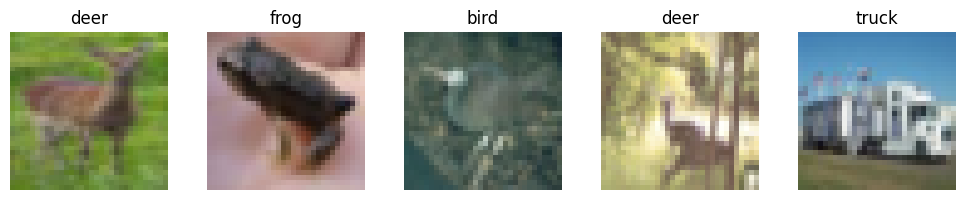

In [107]:
# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# Select 5 random indices
indices = np.random.choice(X_train.shape[1], 5, replace=False)

# Plot the 5 samples
plt.figure(figsize=(10, 2))
for i, idx in enumerate(indices):
    img = X_train[:, idx].reshape(32, 32, 3)  # reshape to image
    label = np.argmax(Y_train[:, idx])        # get label index

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(class_names[label])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [108]:
# Printing shapes and samples to better define the neural netowrk
print("X_train shape:", X_train.shape)
print("X_train shape:", X_test.shape)
print("X_train sample:", X_train[0])

print("\n")

print("y_train sample:", y_train.shape)
print("y_test shape:", y_test.shape)
print("Y_train sample:", y_train[:, 0])

X_train shape: (3072, 50000)
X_train shape: (3072, 10000)
X_train sample: [0.23137255 0.60392157 1.         ... 0.1372549  0.74117647 0.89803922]


y_train sample: (50000, 1)
y_test shape: (10000, 1)
Y_train sample: [6 9 9 ... 9 1 1]


### **3 - Experimentation**

### **Model 1: 2 Hidden Layers, ReLU Activation**
1. Layer 1: 512 neurons with He initialization and ReLU activation, capturing broad patterns from the input.
2. Layer 2: 128 neurons, also with He initialization and ReLU activation, refining the learned representations.

The final output layer is a dense layer with 10 units, using Xavier initialization, followed by a Softmax activation to produce a probability distribution over 10 classes.

In [77]:
# Architecture: [3072] → [512] → [128] → [10]
Z1 = LinearLayer(input_shape=X_train.shape, n_out=512, ini_type='he')
A1 = ReLULayer(Z1.Z.shape)

Z2 = LinearLayer(input_shape=A1.A.shape, n_out=128, ini_type='he')
A2 = ReLULayer(Z2.Z.shape)

Z3 = LinearLayer(input_shape=A2.A.shape, n_out=10, ini_type='xavier')
A3 = SoftmaxLayer(Z3.Z.shape)

In [81]:
# 3. Training Setup
epochs = 20
lr = 0.001
batch_size = 128
costs = []

for epoch in range(epochs):
    permutation = np.random.permutation(X_train.shape[1])
    X_shuffled = X_train[:, permutation]
    Y_shuffled = Y_train[:, permutation]

    for i in range(0, X_train.shape[1], batch_size):
        x_batch = X_shuffled[:, i:i+batch_size]
        y_batch = Y_shuffled[:, i:i+batch_size]

        # Forward pass
        Z1.forward(x_batch)
        A1.forward(Z1.Z)

        Z2.forward(A1.A)
        A2.forward(Z2.Z)

        Z3.forward(A2.A)
        A3.forward(Z3.Z)

        # Compute loss and backprop
        cost, dA3 = compute_cross_entropy_loss(y_batch, A3.A)
        A3.backward(dA3)
        Z3.backward(A3.dZ)

        A2.backward(Z3.dA_prev)
        Z2.backward(A2.dZ)

        A1.backward(Z2.dA_prev)
        Z1.backward(A1.dZ)

        # Update
        Z3.update_params(lr)
        Z2.update_params(lr)
        Z1.update_params(lr)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {cost:.4f}")
    costs.append(cost)

Epoch 1/20, Loss: 2.3816
Epoch 2/20, Loss: 2.3031
Epoch 3/20, Loss: 2.3034
Epoch 4/20, Loss: 2.3028
Epoch 5/20, Loss: 2.3027
Epoch 6/20, Loss: 2.3016
Epoch 7/20, Loss: 2.3013
Epoch 8/20, Loss: 2.3044
Epoch 9/20, Loss: 2.3018
Epoch 10/20, Loss: 2.3050
Epoch 11/20, Loss: 2.3028
Epoch 12/20, Loss: 2.3052
Epoch 13/20, Loss: 2.3020
Epoch 14/20, Loss: 2.3064
Epoch 15/20, Loss: 2.3041
Epoch 16/20, Loss: 2.3033
Epoch 17/20, Loss: 2.3027
Epoch 18/20, Loss: 2.3013
Epoch 19/20, Loss: 2.3023
Epoch 20/20, Loss: 2.3040


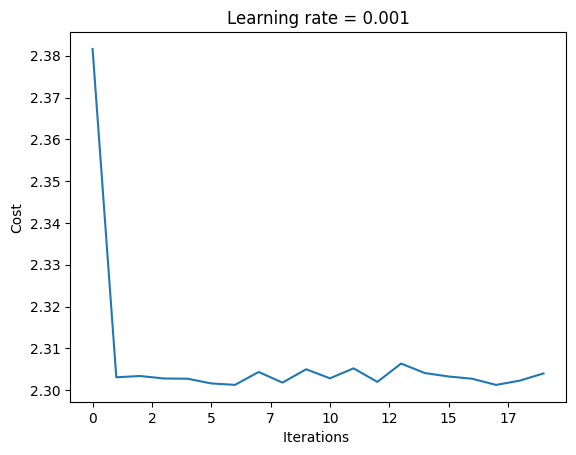

In [82]:
# Plot learning curve
plot_learning_curve(costs=costs, learning_rate=lr, total_epochs=epochs)

The loss stabablizes after the first epoch at 2.30 and remains somewhat the same for the next 19 epochs. This indicates that 1) increasing the number of epochs will not help the model learn better because 2) the model is too simple. We can also see this from the loss magnitude; it is significantly high which indicates very low classification accuracy. 

In [83]:
# Evaluation function
def evaluate(X, Y):
    Z1.forward(X)
    A1.forward(Z1.Z)
    
    Z2.forward(A1.A)
    A2.forward(Z2.Z)
    
    Z3.forward(A2.A)
    A3.forward(Z3.Z)
    
    predictions = np.argmax(A3.A, axis=0)
    labels = np.argmax(Y, axis=0)
    return np.mean(predictions == labels)

# Evaluate test accuracy
accuracy = evaluate(X_test, Y_test)
print(f"Test accuracy: {accuracy * 100:.2f}%")

Test accuracy: 10.00%


A very depressing accuracy. Despite preparing the data as required and increasing the number of epochs, the accuracy is very low. The model works better predicting at random. Hence, we must increase the complexity of the model to help it learn the data more.

### **Model 2: 3 Hidden Layers, ReLU Activation**
1. Dense (linear) layer with 1024 units, using He initialization, followed by a ReLU activation.
2. Dense layer with 512 units, also with He initialization, followed by a ReLU activation.
3. Dense layer with 256 units, again using He initialization, followed by a ReLU activation.

The final output layer is a dense layer with 10 units, using Xavier initialization, followed by a Softmax activation to produce a probability distribution over 10 classes.

In [46]:
# Input: 3072 → [1024 → ReLU] → [512 → ReLU] → [256 → ReLU] → [10 → Softmax]
Z1 = LinearLayer(input_shape=(X_train.shape), n_out=1024, ini_type='he')
A1 = ReLULayer(Z1.Z.shape)

Z2 = LinearLayer(input_shape=A1.A.shape, n_out=512, ini_type='he')
A2 = ReLULayer(Z2.Z.shape)

Z3 = LinearLayer(input_shape=A2.A.shape, n_out=256, ini_type='he')
A3 = ReLULayer(Z3.Z.shape)

Z4 = LinearLayer(input_shape=A3.A.shape, n_out=10, ini_type='xavier')
A4 = SoftmaxLayer(Z4.Z.shape)

In [47]:
epochs = 20
lr = 0.001
batch_size = 64
costs = []

for epoch in range(epochs):
    permutation = np.random.permutation(X_train.shape[1])
    X_shuffled = X_train[:, permutation]
    Y_shuffled = Y_train[:, permutation]
    
    for i in range(0, X_train.shape[1], batch_size):
        X_batch = X_shuffled[:, i:i+batch_size]
        Y_batch = Y_shuffled[:, i:i+batch_size]

        # Forward pass
        Z1.forward(X_batch)
        A1.forward(Z1.Z)
        
        Z2.forward(A1.A)
        A2.forward(Z2.Z)
        
        Z3.forward(A2.A)
        A3.forward(Z3.Z)
        
        Z4.forward(A3.A)
        A4.forward(Z4.Z)

        # Loss + Backpropagation
        cost, dA4 = compute_cross_entropy_loss(Y_batch, A4.A)
        
        A4.backward(dA4)
        Z4.backward(A4.dZ)
        
        A3.backward(Z4.dA_prev)
        Z3.backward(A3.dZ)
        
        A2.backward(Z3.dA_prev)
        Z2.backward(A2.dZ)
        
        A1.backward(Z2.dA_prev)
        Z1.backward(A1.dZ)
        
        # Parameter update
        Z4.update_params(lr)
        Z3.update_params(lr)
        Z2.update_params(lr)
        Z1.update_params(lr)
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {cost:.4f}")
    costs.append(cost)


Epoch 1/20, Loss: 1.7690
Epoch 2/20, Loss: 1.8301
Epoch 3/20, Loss: 1.5690
Epoch 4/20, Loss: 1.2278
Epoch 5/20, Loss: 1.7164
Epoch 6/20, Loss: 1.3316
Epoch 7/20, Loss: 1.1194
Epoch 8/20, Loss: 1.5480
Epoch 9/20, Loss: 1.2395
Epoch 10/20, Loss: 1.7791
Epoch 11/20, Loss: 0.9894
Epoch 12/20, Loss: 1.2395
Epoch 13/20, Loss: 1.4508
Epoch 14/20, Loss: 0.9377
Epoch 15/20, Loss: 1.1777
Epoch 16/20, Loss: 1.3782
Epoch 17/20, Loss: 1.2653
Epoch 18/20, Loss: 1.3196
Epoch 19/20, Loss: 1.0622
Epoch 20/20, Loss: 0.5687


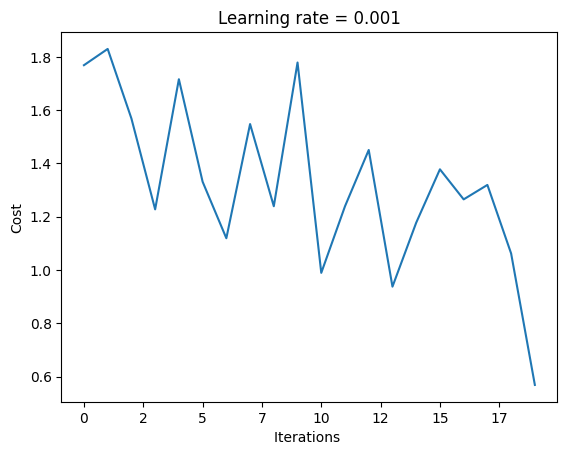

In [60]:
plot_learning_curve(costs=costs, learning_rate=lr, total_epochs=20)

A notable drop in loss relative to Model 1. We can observe a decreasing trend as well. Increasing the number of epochs with this model architecture gives the model potential to converge to its lowest loss value. This architecture gives hope that increasing the model complexity is a driver to bettering the model accuracy.

In [48]:
def evaluate(X, Y):
    Z1.forward(X)
    A1.forward(Z1.Z)
    
    Z2.forward(A1.A)
    A2.forward(Z2.Z)
    
    Z3.forward(A2.A)
    A3.forward(Z3.Z)
    
    Z4.forward(A3.A)
    A4.forward(Z4.Z)
    
    predictions = np.argmax(A4.A, axis=0)
    labels = np.argmax(Y, axis=0)
    return np.mean(predictions == labels)

accuracy = evaluate(X_test, Y_test)
print(f"Test accuracy: {accuracy * 100:.2f}%")


Test accuracy: 53.59%


A massive increase in accuracy between Model 1 and 2. A strong 43.59% increase after addding one more hidden layer to the network. This is a strong indicator that Model 1 was severly underfitting and the CIFAR-10 dataset requires a larger and more complex model to better its accuracy. We may predict that continuously increasing the model size and architecture will continuously better the model accuracy as seen in the Model 1 - Model 2 case.

### **Model 3: 4 Hidden Layers, ReLU Activation**
1. Dense layer with 1024 neurons, initialized with He initialization, followed by a ReLU activation.
2. The second layer has 512 neurons, again using He initialization and ReLU activation.
3. The third layer has 256 neurons, also using He initialization and ReLU activation.
4. The fourth layer reduces the dimensionality further with 128 neurons, initialized with He and followed by ReLU.

The final output layer has 10 neurons, initialized with Xavier initialization, and applies a Softmax activation to output class probabilities.

In [96]:
# Define architecture
# Input: 3072 → [1024 → ReLU] → [512 → ReLU] → [256 → ReLU] → [128 → ReLU] → [10 → Softmax]
Z1 = LinearLayer(input_shape=(X_train.shape), n_out=1024, ini_type='he')
A1 = ReLULayer(Z1.Z.shape)

Z2 = LinearLayer(input_shape=A1.A.shape, n_out=512, ini_type='he')
A2 = ReLULayer(Z2.Z.shape)

Z3 = LinearLayer(input_shape=A2.A.shape, n_out=256, ini_type='he')
A3 = ReLULayer(Z3.Z.shape)

Z4 = LinearLayer(input_shape=A3.A.shape, n_out=128, ini_type='he')
A4 = ReLULayer(Z4.Z.shape)

Z5 = LinearLayer(input_shape=A4.A.shape, n_out=10, ini_type='xavier')
A5 = SoftmaxLayer(Z5.Z.shape)

In [66]:
# Train loop
epochs = 20
lr = 0.001
batch_size = 64
costs = []

for epoch in range(epochs):
    permutation = np.random.permutation(X_train.shape[1])
    X_shuffled = X_train[:, permutation]
    Y_shuffled = Y_train[:, permutation]
    
    for i in range(0, X_train.shape[1], batch_size):
        X_batch = X_shuffled[:, i:i+batch_size]
        Y_batch = Y_shuffled[:, i:i+batch_size]

        # Forward pass
        Z1.forward(X_batch)
        A1.forward(Z1.Z)
        
        Z2.forward(A1.A)
        A2.forward(Z2.Z)
        
        Z3.forward(A2.A)
        A3.forward(Z3.Z)
        
        Z4.forward(A3.A)
        A4.forward(Z4.Z)
        
        Z5.forward(A4.A)
        A5.forward(Z5.Z)

        # Loss + Backpropagation
        cost, dA5 = compute_cross_entropy_loss(Y_batch, A5.A)
        
        A5.backward(dA5)
        Z5.backward(A5.dZ)
        
        A4.backward(Z5.dA_prev)
        Z4.backward(A4.dZ)
        
        A3.backward(Z4.dA_prev)
        Z3.backward(A3.dZ)
        
        A2.backward(Z3.dA_prev)
        Z2.backward(A2.dZ)
        
        A1.backward(Z2.dA_prev)
        Z1.backward(A1.dZ)
        
        # Parameter update
        Z5.update_params(lr)
        Z4.update_params(lr)
        Z3.update_params(lr)
        Z2.update_params(lr)
        Z1.update_params(lr)
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {cost:.4f}")
    costs.append(cost)

Epoch 1/20, Loss: 2.3783
Epoch 2/20, Loss: 1.7555
Epoch 3/20, Loss: 1.8052
Epoch 4/20, Loss: 1.3538
Epoch 5/20, Loss: 1.9803
Epoch 6/20, Loss: 2.0172
Epoch 7/20, Loss: 1.1926
Epoch 8/20, Loss: 1.4689
Epoch 9/20, Loss: 1.2863
Epoch 10/20, Loss: 1.2594
Epoch 11/20, Loss: 1.4823
Epoch 12/20, Loss: 0.6456
Epoch 13/20, Loss: 0.6773
Epoch 14/20, Loss: 1.2651
Epoch 15/20, Loss: 1.8390
Epoch 16/20, Loss: 1.0550
Epoch 17/20, Loss: 0.9355
Epoch 18/20, Loss: 0.7322
Epoch 19/20, Loss: 0.8487
Epoch 20/20, Loss: 1.0545


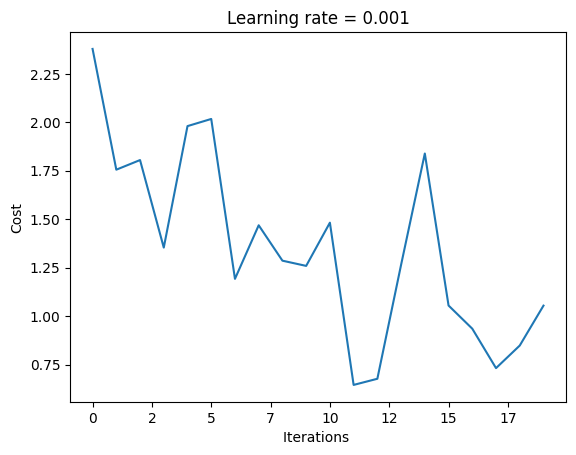

In [67]:
# Plot learning curve
plot_learning_curve(costs=costs, learning_rate=lr, total_epochs=epochs)

Very similar performance with Model 2 despite an increase in hidden layers. We still observe somewhat of a decreasing trend with the loss plot, however, the spikes remain noticeable and it seems the loss will increase in the next epochs.

In [68]:
# Evaluation function
def evaluate(X, Y):
    Z1.forward(X)
    A1.forward(Z1.Z)
    
    Z2.forward(A1.A)
    A2.forward(Z2.Z)
    
    Z3.forward(A2.A)
    A3.forward(Z3.Z)
    
    Z4.forward(A3.A)
    A4.forward(Z4.Z)
    
    Z5.forward(A4.A)
    A5.forward(Z5.Z)
    
    predictions = np.argmax(A5.A, axis=0)
    labels = np.argmax(Y, axis=0)
    return np.mean(predictions == labels)

# Test accuracy
accuracy = evaluate(X_test, Y_test)
print(f"Test accuracy: {accuracy * 100:.2f}%")


Test accuracy: 52.15%


The accuracy has dropped despite increasing the number of hidden layers and activation neurons, which goes against the initial hypothesis that the model is performing poorly because it is too simple. Yet, we cannot reject this underfitting statement yet as the accuracy drop is small and could be overlooked if a more complex model performs better. Hence, let's try defining a larger model with 5 hidden layers to diagnose the issue better.

### **Model 4: 5 Hidden Layers, ReLU Activation**
1. Layer 1: Dense layer with 1024 neurons, using He initialization and ReLU activation.
2. Layer 2: Dense layer with 512 neurons, He initialization, ReLU activation.
3. Layer 3: Dense layer with 256 neurons, He initialization, ReLU activation.
4. Layer 4: Dense layer with 128 neurons, He initialization, ReLU activation.
5. Layer 5: Dense layer with 64 neurons, also using He initialization and ReLU activation—this adds another level of abstraction and non-linearity.

Output Layer: Dense layer with 10 neurons, Xavier initialization, followed by Softmax activation to produce class probabilities.

In [69]:
# Define architecture
Z1 = LinearLayer(input_shape=(X_train.shape), n_out=1024, ini_type='he')
A1 = ReLULayer(Z1.Z.shape)

Z2 = LinearLayer(input_shape=A1.A.shape, n_out=512, ini_type='he')
A2 = ReLULayer(Z2.Z.shape)

Z3 = LinearLayer(input_shape=A2.A.shape, n_out=256, ini_type='he')
A3 = ReLULayer(Z3.Z.shape)

Z4 = LinearLayer(input_shape=A3.A.shape, n_out=128, ini_type='he')
A4 = ReLULayer(Z4.Z.shape)

Z5 = LinearLayer(input_shape=A4.A.shape, n_out=64, ini_type='he')     # new layer
A5 = ReLULayer(Z5.Z.shape)                                           # new activation

Z6 = LinearLayer(input_shape=A5.A.shape, n_out=10, ini_type='xavier')
A6 = SoftmaxLayer(Z6.Z.shape)

In [70]:
for epoch in range(epochs):
    permutation = np.random.permutation(X_train.shape[1])
    X_shuffled = X_train[:, permutation]
    Y_shuffled = Y_train[:, permutation]
    
    for i in range(0, X_train.shape[1], batch_size):
        X_batch = X_shuffled[:, i:i+batch_size]
        Y_batch = Y_shuffled[:, i:i+batch_size]

        # Forward pass
        Z1.forward(X_batch)
        A1.forward(Z1.Z)
        
        Z2.forward(A1.A)
        A2.forward(Z2.Z)
        
        Z3.forward(A2.A)
        A3.forward(Z3.Z)
        
        Z4.forward(A3.A)
        A4.forward(Z4.Z)
        
        Z5.forward(A4.A)
        A5.forward(Z5.Z)
        
        Z6.forward(A5.A)
        A6.forward(Z6.Z)

        # Loss + Backpropagation
        cost, dA6 = compute_cross_entropy_loss(Y_batch, A6.A)
        
        A6.backward(dA6)
        Z6.backward(A6.dZ)
        
        A5.backward(Z6.dA_prev)
        Z5.backward(A5.dZ)
        
        A4.backward(Z5.dA_prev)
        Z4.backward(A4.dZ)
        
        A3.backward(Z4.dA_prev)
        Z3.backward(A3.dZ)
        
        A2.backward(Z3.dA_prev)
        Z2.backward(A2.dZ)
        
        A1.backward(Z2.dA_prev)
        Z1.backward(A1.dZ)
        
        # Parameter update
        Z6.update_params(lr)
        Z5.update_params(lr)
        Z4.update_params(lr)
        Z3.update_params(lr)
        Z2.update_params(lr)
        Z1.update_params(lr)
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {cost:.4f}")
    costs.append(cost)

Epoch 1/20, Loss: 1.7684
Epoch 2/20, Loss: 1.8585
Epoch 3/20, Loss: 1.3771
Epoch 4/20, Loss: 1.9548
Epoch 5/20, Loss: 1.7528
Epoch 6/20, Loss: 1.6165
Epoch 7/20, Loss: 1.2623
Epoch 8/20, Loss: 1.4016
Epoch 9/20, Loss: 1.5440
Epoch 10/20, Loss: 1.6035
Epoch 11/20, Loss: 1.9588
Epoch 12/20, Loss: 1.1297
Epoch 13/20, Loss: 1.5402
Epoch 14/20, Loss: 1.7843
Epoch 15/20, Loss: 0.9358
Epoch 16/20, Loss: 1.4022
Epoch 17/20, Loss: 1.5221
Epoch 18/20, Loss: 0.9333
Epoch 19/20, Loss: 1.3919
Epoch 20/20, Loss: 0.8583


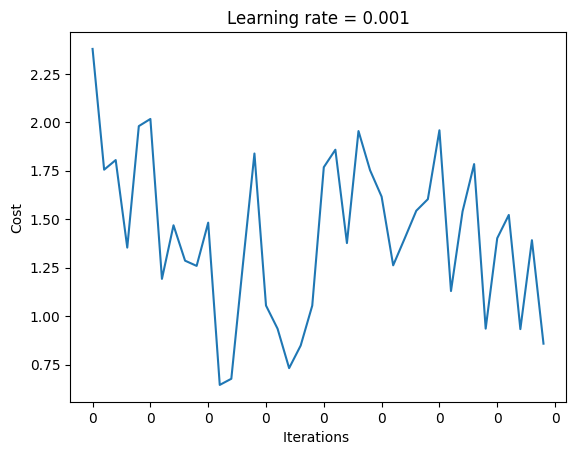

In [75]:
# Plot learning curve
plot_learning_curve(costs=costs, learning_rate=lr, total_epochs=epochs)

Performs somewhat closely to the previous models, this time fluctuating much more. There isn't a noticeable trend in the loss plot due to the fluctuations.

In [76]:
def evaluate(X, Y):
    Z1.forward(X)
    A1.forward(Z1.Z)
    
    Z2.forward(A1.A)
    A2.forward(Z2.Z)
    
    Z3.forward(A2.A)
    A3.forward(Z3.Z)
    
    Z4.forward(A3.A)
    A4.forward(Z4.Z)
    
    Z5.forward(A4.A)
    A5.forward(Z5.Z)
    
    Z6.forward(A5.A)
    A6.forward(Z6.Z)
    
    predictions = np.argmax(A6.A, axis=0)
    labels = np.argmax(Y, axis=0)
    return np.mean(predictions == labels)

# Test accuracy
accuracy = evaluate(X_test, Y_test)
print(f"Test accuracy: {accuracy * 100:.2f}%")

Test accuracy: 48.77%


Surprisingly, the accuracy dropped when increasing the complexity of the neural network. This was predicted from the loss logs observed during training, as they were not improving and rather fluctuating around despite setting a low learning rate. It seems that the hyperparamters we are flexible with are not enough to better the accuracy of the model. 

At first, it was predicted that the model could be underfitting to the data; that it is too simple to grasp the underlying pattern. The results between Model 1 and Model 2 provided evidence to believe so. We observed a spiking increase between the two models which suggested that adding more layers and making the model more complex was the solution. Which is no longer the case.

Model 3 performed closely to Model 2, slightly lower in accuracy. This was not enough to reject the underfitting hypothesis yet. Hence, I trained Model 4 with 5 hidden layers, and verily a lower accuracy. This shows that 1) increasing the complexity of the model architecture will not help increase the accuracy of the model and 2) the reason for this is because the hyperparamters chosen alone are not strong enough to truly understand the data. So, this case of underfitting can possibly be solved by adding more hyperparamters or defining a dropout layer for instance.

In fact, this drop in accuracy observed after continuously increasing the number of hidden layers suggests the model is also overfitting as now it has become too complex and memorizes the data more, hence generalizing poorly.

### **3 - Performance Evaluation**
The accuracies found in this assignment are far from the state-of-the-art results, which reach up to 96.53% as seen in https://arxiv.org/abs/1412.6071. The idea was to understand how neural networks flow beyond liraries and equations. 

Moreover, it is also worth to note that state-of-the-art results rely on more advanced models that outperform basic neural networks in image classification tasks as seen in the CIFAR-10 case. Below are a few diffrentiating factors 

Fully connected neural networks (FCNs) require the input data to be flattened into a 1D vector, which loses spatial structure present in image data. Images, by their very nature, have spatial hierarchies where local patterns (like edges, textures, and shapes) are important for recognizing objects. 

CNNs, on the other hand, preserve this spatial information through convolutional layers. These layers detect patterns by applying small filters across the image, capturing local features at multiple levels, which is critical for achieving high accuracy on image datasets like CIFAR-10. 

Furthermore, top-performing models in the literature benefit from advanced architectures (e.g., ResNet), regularization, data augmentation, better optimizers, and sometimes pretraining on large datasets—none of which a basic neural net from scratch typically includes.